# Ensemble Method
## Implemented in PyTorch for a cubic polynomial/toy dataset

In [84]:
# NumPy for toy dataset generation
import numpy as np
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
# Import PyTorch
import torch
# Import math module
import math
# For properly copying model architectures to generate ensembles
import copy

# Setting figure quality
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'

## Defining a Custom Dataset Class, Data Generation Function, and Plotting Function

In [85]:
# PyTorch design philosophy asks for any training dataset to be loaded into a PyTorch "Dataset" class.
# We'll do this here. When the dataset class is written, it can be passed to a PyTorch DataLoader which
# controls how the data is fed to the model. We'll define a DataLoader later.
class Polynomial_Dataset(torch.utils.data.Dataset):
    def __init__(self, xLow, xHigh, numPoints, train = True):
        # Generate our polynomial dataset from our custom data generation function
        xData, yData = generate_data(xLow, xHigh, numPoints, train)
        # Convert to tensures, ensure float32 values
        self.xData = torch.as_tensor(xData.copy(), dtype = torch.float32).view(numPoints, 1)
        self.yData = torch.as_tensor(yData.copy(), dtype = torch.float32).view(numPoints, 1)
        
        # NumPy array versions of the data
        self.xDataNP = self.xData.numpy().copy().astype("float32")
        self.yDataNP = self.yData.numpy().copy().astype("float32")
        
        # Descriptive information about the dataset
        # Length
        self.length = numPoints
        # Theoretical lowest value
        self.xLow = xLow
        # Theoretical highest value
        self.xHigh = xHigh

    # The dataset needs to be iterable (i.e. accessible by an index or some custom enumeration)
    # So, we define a method for accessing the dataset here.
    def __getitem__(self, idx):  
        # Get x-Value based on index
        xItem = self.xDataNP.item(idx)
        # Get y-Value baesd on index
        yItem = self.yDataNP.item(idx)
        
        # Return an ordered pair of points
        return (xItem, yItem)
    
    # Additionally, PyTorch DataLoader compatibility requires our dataset to have a length function.
    # Returns dataset # of samples
    def __len__(self):
        return self.length
    
# Function for generating the polynomial dataset
def generate_data(xLow, xHigh, numPoints, train = True):
    # Generate domain values
    x = np.linspace(xLow, xHigh, numPoints)
    # We want the dataset to be an xy array, so add an extra axis for y values via expand_dims
    # Additionally, ensure that values in the dataset are 32-bit floating point numbers.
    x = np.expand_dims(x, 1).astype(np.float32)
    
    # Establish standard deviation (i.e. uncertainty) for each datapoint.
    # Default to 3 standard deviations
    
    # If we are generating training data, then we will explicitly tell the model what the uncertainty is
    # because we are doing supervised learning.
    #  np.ones_like makes a constant array of 1's in the shape of x
    if train:
        sigma = 3*np.ones_like(x)
    # Otherwise if we are generating test data, we want the model to guess uncertainty without
    # being explicitly told what the answer is.
    # np.zeroes_like makes a constant array of 0's in the shape of x
    else:
        sigma = 3*np.zeros_like(x)
    
    # Generate the dataset using our x points. If it is training data, generate Gaussian uncertainty based 
    # on how 'sigma' was defined. If it is test data, do not generate uncertainty values.
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)
    
    return x,y

# Function for plotting predictions
def plot_predictions(xTrain, yTrain, xTest, yTest, yPred, yStd, numFolds, nStds=4, kk=0):

    # All the tensors are of shape [#Rows, 1]
    # Convert the tensors into shape [#Row] via torch.flatten such that they can be plotted without error.
    xTrain = torch.flatten(xTrain)
    yTrain = torch.flatten(yTrain)
    xTest = torch.flatten(xTest)
    yTest = torch.flatten(yTest)
    mu = torch.flatten(yPred)
    var = torch.flatten(yStd)
    var = np.minimum(var, 1e3)
    
    # Plotting Code
    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(xTrain, yTrain, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(xTest, yTest, 'r--', zorder=2, label="True")
    plt.plot(xTest, mu, color='#007cab', zorder=3, label="Prediction")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    
    # Shade the area of uncertainty associated with the toy dataset
    for k in np.linspace(0, nStds, 4):
        plt.fill_between(
            xTest, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Uncertainty" if k == 0 else None)
    
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.title("Ensemble Method\n(" + str(numFolds) + "-fold Ensemble)")
    plt.show()

## Defining a Custom Dataset Class, Data Generation Function, and Plotting Function

In [86]:
# Creating the PyTorch Model Class for the ANN.
class ANN(torch.nn.Module):
    
    def __init__(self, numInputs = 64, numOutputs = 64):
        super(ANN, self).__init__()
        
        self.linear1 = torch.nn.Linear(numInputs, numOutputs)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(numOutputs, numOutputs)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(numOutputs, 1)
        
    # Define forward passing of the neural network
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        
        return x

## Defining a Custom Evidential Loss Function

In [87]:
def MAE(y, yPred, reduce=True):
    # Get the predictive error
    error = torch.abs(y - yPred)
    
    return torch.mean(error) if reduce else error

## Generate Training/Test Data

In [104]:
# Set a global NumPy seed for random number generation, improves reproducibility.
np.random.seed(0)
# Set a global PyTorch seed for random number generation, improves reproducibility.
torch.manual_seed(0)

# Number of folds for ensemble training
numFolds = 6

# Total number of training points desired
numTrainPoints = numFolds*1000
# Number of training points in each ensemble fold training subset
numTrainPointsFold = math.ceil(numTrainPoints/numFolds)

# Specify the lower domain x Value of the training data
lowDomain = -4
# Specify the higher domain x Value of the training data
highDomain = 4
# Total domain length
domain = abs(highDomain - lowDomain)
# Ensemble fold step-size based on the total domain length,
# This is for automatically generating ensemble training sets in a way that is invariant to domain length
domainStepSize = domain/numFolds

# Store ensemble training datasets
ensembleSubsets = []

# Generate ensemble training subsets, which are specifically folds
for fold in range(1, numFolds + 1):
    
    # Lower domain value of fold
    lowDomainFold = lowDomain + (fold - 1)*domainStepSize
    # Higher domain value of fold
    highDomainFold = lowDomain + (fold*domainStepSize)
    
    # Generate data for the current fold
    foldPoints = Polynomial_Dataset(lowDomainFold, highDomainFold, numTrainPointsFold, train = True)
    ensembleSubsets.append(foldPoints)
    
testData = Polynomial_Dataset(-7, 7, 1000, train = False)

## Define a Dataloader for Feeding Data to Model

In [105]:
# Specify a batch size to load into the model for mini-batch optimization.
trainBatchSize = 100
# Specify a batch size to load into the model for making test predictions.
evalBatchSize = trainBatchSize

# Create a dataloader for each ensemble subsplit
# PyTorch design philosophy uses "DataLoader" objects to feed the data to the ML model during training and inference
# One defines a DataLoader and then passes the data to it.

ensembleTrainDL = []

for fold in range(numFolds):
    trainDL = torch.utils.data.DataLoader(ensembleSubsets[fold], batch_size = trainBatchSize, shuffle = False)
    ensembleTrainDL.append(trainDL)

testDL = torch.utils.data.DataLoader(testData, batch_size = evalBatchSize, shuffle = False)


## Instantiate the Model Before Training

In [106]:
# Instantiate the model and print the model architecture.
myModel = ANN(numInputs = 1)

# Cast all model parameters to 64-bit floating point numbers
# All the numbers have the be the same datatype (i.e. 64-bit) for PyTorch to accept the data
myModel = myModel.double()

# We want to train a model for each fold in the ensemble, but we want to use
# the exact same model architecture between folds. So, store all these copies in a list.
ensembleModels = []

for fold in range(numFolds):
    # Python is a pointer-based programming language when defining variables,
    # Meaning that variables often point to the same location in memory
    # e.g., x = 2 and y = 2 often point to the same '2' in memory.
    # We want truly separate but identical model architectures
    # So, we need to ensure there are separate copies of the model in memory
    # We can do this with copy.deepcopy()
    ensembleModels.append(copy.deepcopy(myModel))

## Instantiate an Optimizer Before Training

In [107]:
ensembleOptimizers = []

# Create an optimizer for each ensemble fold
for fold in range(numFolds):
    optimizer = torch.optim.Adam(ensembleModels[fold].parameters(), lr = 5e-4, eps = 1e-07)
    ensembleOptimizers.append(optimizer)

## Train the model

In [108]:
# Number of epochs to train for.
numEpoch = 500

# Perform training on each fold in the ensemble
for fold in range(numFolds):
    
    for epoch in range(numEpoch):
        lossCounter = 0.0

        # Get the data
        for batchIndex, batchData in enumerate(ensembleTrainDL[fold]):

            xData = batchData[0]
            xData = xData.view(trainBatchSize, 1)
            yData = batchData[1]
            yData = yData.view(trainBatchSize, 1)

            # Zero the parameter gradients between each epoch (because we start fresh with the training each epoch)
            ensembleOptimizers[fold].zero_grad()

            # Forward passing
            outputs = ensembleModels[fold](xData)
            # Calculating loss
            loss = MAE(yData, outputs)
            # Backwards passing, automatically performed
            loss.backward()
            # Continue with optimization
            ensembleOptimizers[fold].step()

            # Statistics to show training
            lossCounter += loss.item()
            # Every 10 mini-batches and 5 epochs, print
            if (batchIndex%10 == 9) and (epoch%5 == 4):
                print("[%d, %5d] loss: %.3f" % (epoch + 1, batchIndex + 1, lossCounter/10))
                epochLoss = lossCounter
                # Reset the loss counter for the next set of mini-batches
                lossCounter = 0.0

    print("\nTraining Complete.\n")

    # Final training statistics
    print("Final loss: %.3f" % (epochLoss/10))

[5,    10] loss: 36.115
[10,    10] loss: 31.301
[15,    10] loss: 22.318
[20,    10] loss: 11.232
[25,    10] loss: 8.494
[30,    10] loss: 8.269
[35,    10] loss: 8.228
[40,    10] loss: 8.207
[45,    10] loss: 8.192
[50,    10] loss: 8.179
[55,    10] loss: 8.165
[60,    10] loss: 8.152
[65,    10] loss: 8.140
[70,    10] loss: 8.127
[75,    10] loss: 8.115
[80,    10] loss: 8.103
[85,    10] loss: 8.091
[90,    10] loss: 8.079
[95,    10] loss: 8.067
[100,    10] loss: 8.056
[105,    10] loss: 8.043
[110,    10] loss: 8.032
[115,    10] loss: 8.021
[120,    10] loss: 8.009
[125,    10] loss: 7.998
[130,    10] loss: 7.987
[135,    10] loss: 7.975
[140,    10] loss: 7.964
[145,    10] loss: 7.953
[150,    10] loss: 7.941
[155,    10] loss: 7.930
[160,    10] loss: 7.919
[165,    10] loss: 7.907
[170,    10] loss: 7.896
[175,    10] loss: 7.884
[180,    10] loss: 7.872
[185,    10] loss: 7.860
[190,    10] loss: 7.848
[195,    10] loss: 7.837
[200,    10] loss: 7.825
[205,    10] los

[160,    10] loss: 2.420
[165,    10] loss: 2.419
[170,    10] loss: 2.419
[175,    10] loss: 2.419
[180,    10] loss: 2.419
[185,    10] loss: 2.419
[190,    10] loss: 2.419
[195,    10] loss: 2.419
[200,    10] loss: 2.419
[205,    10] loss: 2.419
[210,    10] loss: 2.418
[215,    10] loss: 2.418
[220,    10] loss: 2.418
[225,    10] loss: 2.418
[230,    10] loss: 2.418
[235,    10] loss: 2.418
[240,    10] loss: 2.418
[245,    10] loss: 2.418
[250,    10] loss: 2.418
[255,    10] loss: 2.417
[260,    10] loss: 2.417
[265,    10] loss: 2.417
[270,    10] loss: 2.417
[275,    10] loss: 2.417
[280,    10] loss: 2.417
[285,    10] loss: 2.417
[290,    10] loss: 2.417
[295,    10] loss: 2.417
[300,    10] loss: 2.417
[305,    10] loss: 2.416
[310,    10] loss: 2.416
[315,    10] loss: 2.416
[320,    10] loss: 2.416
[325,    10] loss: 2.416
[330,    10] loss: 2.416
[335,    10] loss: 2.416
[340,    10] loss: 2.416
[345,    10] loss: 2.416
[350,    10] loss: 2.416
[355,    10] loss: 2.416


## Make Predictions with the Model

In [109]:
# The model is now trained, so let's make some predictions on the test dataset.

# Disable the autograd engine, as we only need gradients in our model during training.
# Disabling this improves inference speed

# Store predictions for each fold
# The idea is that each fold's predictions can be averaged together to get a mean prediction.
# Standard deviation can be calculated to get the uncertainty of each prediction.

ensemblePredictions = []

for fold in range(numFolds):
    with torch.no_grad():

        # Set the model into evaluation mode. This ensures all model layers behave properly while making predictions.
        ensembleModels[fold].eval()

        # Get the data
        for batchIndex, batchData in enumerate(testDL):

            xData = batchData[0]
            xData = xData.view(evalBatchSize, 1)

            # Make Predictions
            outputs = ensembleModels[fold](xData)

            # Take each mini-batch prediction set and combine them via concatenation to get the total prediction set.
            if batchIndex != 0:
                # Make Predictions
                outputs = ensembleModels[fold](xData)
                outputs = torch.cat((previousOutputs, outputs), dim = 0)
                previousOutputs = outputs
            else:
                previousOutputs = ensembleModels[fold](xData)

    print("\nInference Complete.\n")
    print("Prediction Set Dimensions:")
    print(outputs.size())
    
    ensemblePredictions.append(outputs)



Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 1])

Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 1])

Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 1])

Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 1])

Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 1])

Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 1])


## Plot Prediction Trendline with the Real Data and Real Trendline

tensor([-89.8630], dtype=torch.float64)
tensor([-58.6815], dtype=torch.float64)
tensor([-18.7812], dtype=torch.float64)
tensor([38.6039], dtype=torch.float64)
tensor([-13.2912], dtype=torch.float64)
tensor([-0.4871], dtype=torch.float64)
tensor([-23.7500], dtype=torch.float64)
tensor([45.0652], dtype=torch.float64)


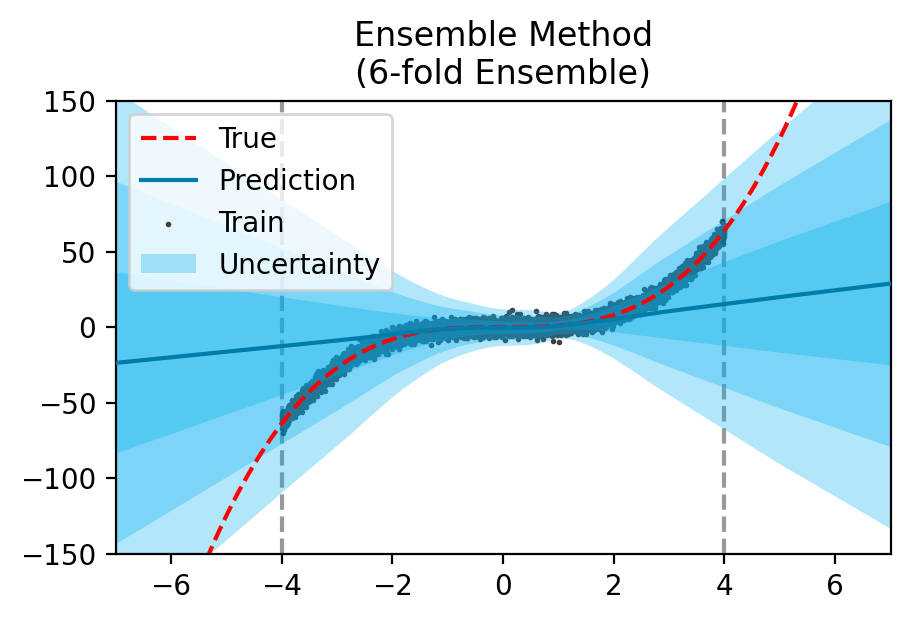

In [113]:
# Average the prediction sets together to get an average prediction trendline
for fold in range(numFolds):
    print(ensemblePredictions[fold][0])
predMean = torch.mean(torch.stack(ensemblePredictions, dim = 0), dim = 0)
# Compute standard deviation of each prediction in the averaged prediction set.
predStd = torch.std(torch.stack(ensemblePredictions, dim = 0), dim = 0)
fullTrainingData = torch.Tensor(np.vstack(ensembleSubsets))

xTrain = fullTrainingData[:, 0]
yTrain = fullTrainingData[:, 1]
xTest = testData.xData
yTest = testData.yData

plot_predictions(xTrain, yTrain, xTest, yTest, predMean, predStd, numFolds)